# Lab #3: 
Written by: Igor Banin
## Asking a statistical question

### Problem 1

Start by simulating 100k 'good' data points assuming Gaussian fluctations, and because we are playing god adding the following 'bad' datapoints: {10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7}

In [2]:
%matplotlib inline
import statistics 
import math 
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy
from scipy import stats
from scipy.stats import chi2_contingency

In [26]:
mu, sigma =  12, 0.4 #Mean should be around 12 Kelvin, 0.4 degree standard deviation
gaussian = np.random.normal(mu, sigma, 100000)
flaws = [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7]
gaussian_with_flaws = np.append(gaussian, flaws)
print(gaussian_with_flaws)

[12.1905262  12.25838338 11.54630324 ... 15.6        22.3
 12.7       ]


#### A) So our goal is to identify bad data and throw it out.

#### 1. Start by exploring the data you have created with appropriate plots

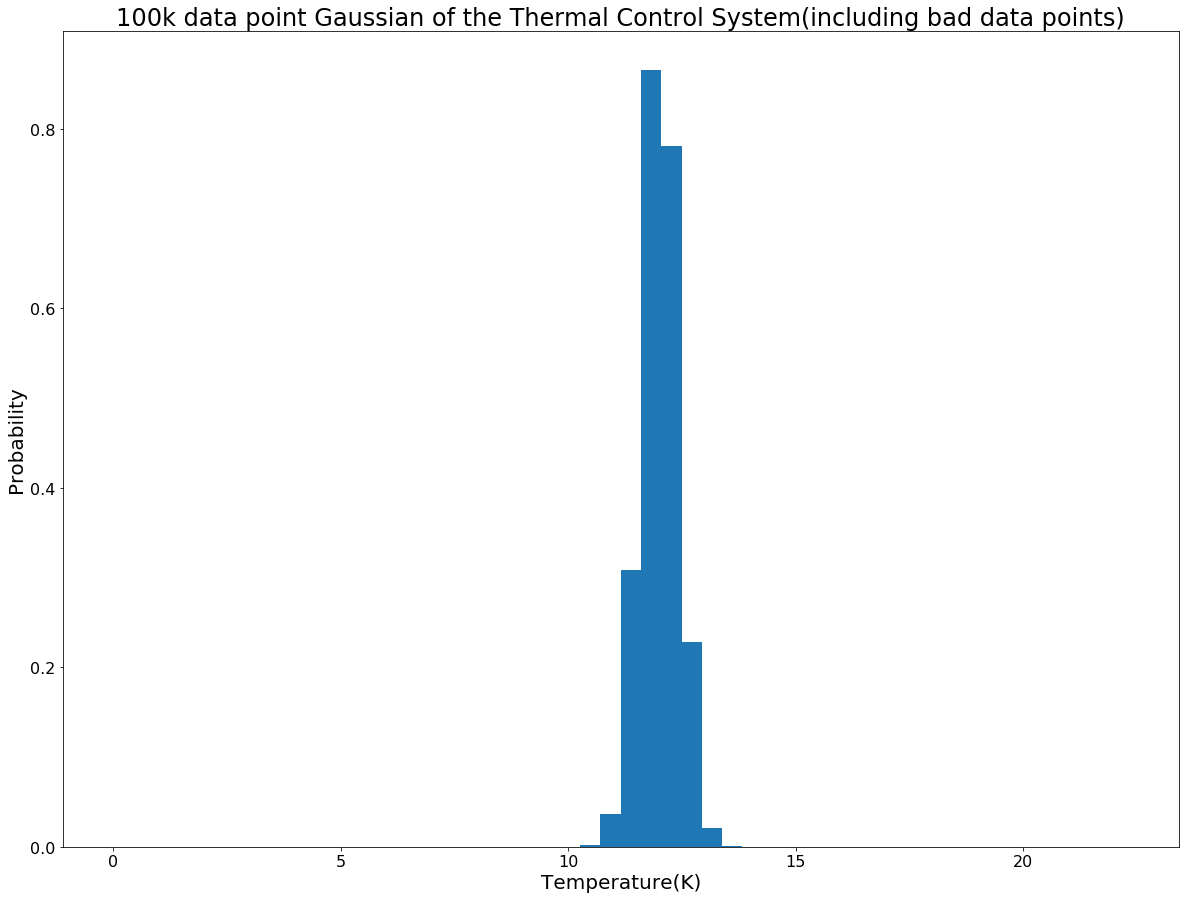

In [28]:
plt.rcParams["figure.figsize"] = (20,15)
fig, ax = plt.subplots(1, 1)
ax.hist(gaussian_with_flaws,50, density=True)
plt.tick_params(labelsize = 16)
plt.title("100k data point Gaussian of the Thermal Control System(including bad data points)"
          ,fontsize=24)
plt.xlabel("Temperature(K)", fontsize = 20)
plt.ylabel('Probability', fontsize = 20)
plt.show()

Our plotted data looks horrendous because in our generated data set we went ahead and placed bad data points at 0 and 22.3. This causes our data to inaccurately represent the variation of thermal control system. 

#### 2. State the statistical question in words. Be very clear, and describe why you have chosen this statistical question. 

What is the probability that the temperature data is a probability of 5-sigma above or below the average of 12 Kelvin, in relation to the standard normal distribution. In this case I will consider that this probability above or below the distribution is considered to be anomalously high and low readings, such that they do not reflect the actual temperature of the thermal control system. In an attempt to cleanse my data, I need to identify these wonky values, to then discard them from the data set.

#### 3. Restate your questin in math. Be very clear.

The 5 sigma point is representative of a an extremely rare event, such that it only happens once every 3.5million events in a standard normal distribution. For our distribution we want to find the equivalent of a 5 sigma point probability of a stanard normal distribution, and identify where this same probability(as a temperature value) lies in our distribution. I will be identifying the range of valid temperature readings that my data will accept by identifying where this -5 sigma and 5 sigma probability points exist on my distribution. Tossing all outliers below the -5 sigma and above the 5 sigma probability points.

#### 4. Apply your statistical test and construct a truth table.

In [40]:
new_std = statistics.stdev(gaussian_with_flaws)
new_mean = statistics.mean(gaussian_with_flaws)
print("Mean: ", new_mean)
print("Standard Deviation: ", new_std)

Mean:  12.00171390377933
Standard Deviation:  0.4057755148042425


As expected the insertion of these bad data points has shifted our mean and standard deviation from the initial 12K mu, and 0.4K standard deviation. We still want to account for the original mean and original standard deviation, unaffected by these outliers.

In [63]:
low_prob = stats.norm.cdf(-5)
high_prob = stats.norm.cdf(5)
print("Everything that falls under the -5 sigma probability of ",
     '%.7f'%(low_prob * 100), "% and 5 sigma probability of ", '%.7f'%(100 - high_prob* 100)
      , "% should be considered anomalously high and discarded from our data set.")
sigma_low = stats.norm.ppf(low_prob, loc=12, scale=0.4)
sigma_high = stats.norm.ppf(high_prob, loc=12, scale=0.4)
print("Lower bound of discarded values: ", sigma_low, "K")
print("Upper bound of discarded values: ", sigma_high, "K")


Everything that falls under the -5 sigma probability of  0.0000287 % and 5 sigma probability of  0.0000287 % should be considered anomalously high and discarded from our data set.
Lower bound of discarded values:  10.0 K
Upper bound of discarded values:  13.99999999998807 K


Using the +/- 5 sigma probability of the normal standard distribution, we are able to find the range of acceptable temperature values. Which turns out to be 10.0K - 13.99999999998807K. This is pretty close to our initial estimate of 12 - 0.4 * 5 and 12 + 0.4 * 5 = 10 - 14K.

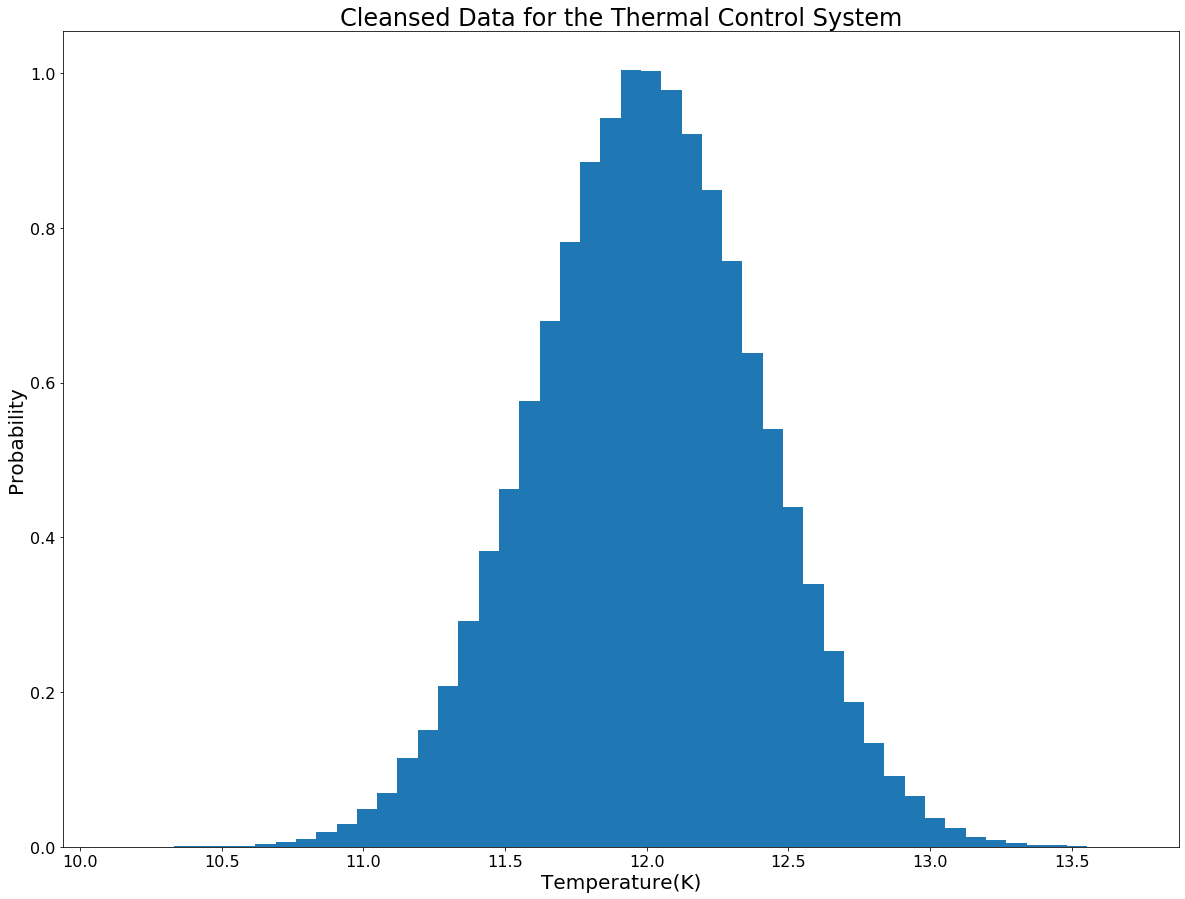

In [55]:
cleansed_data = [x for x in gaussian_with_flaws if (x > sigma_low)]
cleansed_data = [x for x in cleansed_data if (x < sigma_high)]

plt.rcParams["figure.figsize"] = (20,15)
fig, ax = plt.subplots(1, 1)
ax.hist(cleansed_data,50, density=True)
plt.tick_params(labelsize = 16)
plt.title("Cleansed Data for the Thermal Control System"
          ,fontsize=24)
plt.xlabel("Temperature(K)", fontsize = 20)
plt.ylabel('Probability', fontsize = 20)
plt.show()

Cleansing this data for outliers has now made the distribution of the thermal control system to look much more gaussian.

We know from the problem description that we are given 8 bad data points to append to our gaussian. Out of those 8 bad data points({10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7}), we have found that two of these data points fall into the acceptable range of 10.0 < 'acceptable value' < 13.99999999998807. That is the measurement 10.3K, and 12.7K. So that means 2/8 bad data points showed up to be False Positives(bad data that we ended up keeping), while the remaining 6/8 data points were False Negatives(bad data that we correctly discarded).

In [60]:
size = len(cleansed_data)
print(size)
if(10.3 in cleansed_data):
    print("The false positive value 10.3 is contained within the cleansed data.")
if(12.7 in cleansed_data):
    print("The false positive value 12.7 is contained within the cleansed data.")

100002
The false positive value 10.3 is contained within the cleansed data.
The false positive value 12.7 is contained within the cleansed data.


The following test shows that out of the 100k data point generated gaussian that we made, there are 2 extra points. These 2 extra points are the false positives that we appended as part of our 'bad data'. By process of elimination this means that there were no True Negatives(data that was true but happened to be discarded from the cleansed data set).

#### B) How does the number of omissions, where you threw out good data, depend on the statistical threshold you chose and is it a predictable quantity?

Considering a perfectly normal distribution. Disregarding our specified mean and standard deviation. A True Positive 5 sigma event happens once every 3.5 million events. The same probability is true for a -5 sigma event. Therefore the possibility of us throwing out a True Positive(good data), by specifying a range of greater than -5 sigma and less than 5 sigma is 2/3.5 million.

#### C) Are there mistakes of commission (bad data getting in)? If yes, are they avoidable and how do they depend on your statistical threshold?

There is bad data getting, namely the 10.3K and 12.7K values mentioned above. In this case these values are not avoidable because they are perfectly disguised as regular data points falling within the -5sigma to 5 sigma range. It is possible to get rid of the 10.3K false positive by shortening our statistical threshold but that would involve getting rid of a lot of good data. 

In this case in particular, the false positives are statistically indistinguishable from real data. If we had a different data set, we could maybe plot the distribution on a different data set(possibly using other metadata) to try and distinguish between true positives and false positives.

### Problem 2 

In this example we will be looking for asteroids. If we look at the alignment of stars on subsequent images, they don't perfectly align due to atmospheric and instrumental effects (even ignoring proper motion). The resulting distribution is two dimensional, and for this lab let's assume it is a 2D Gaussian with 1 arcsecond RMS. Or said another way, if I histogram how far all the (stationary) stars appear to have moved I get something like:

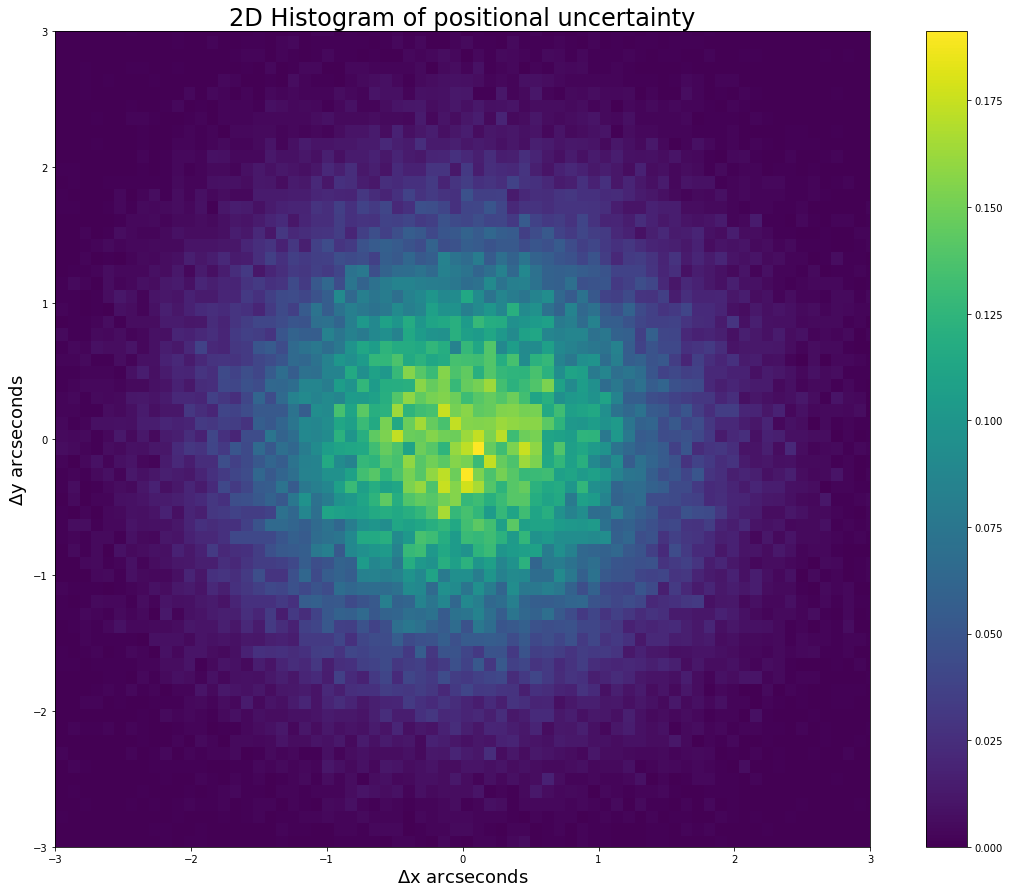

In [64]:
#a = np.concatenate(np.array(stats.norm.rvs( scale = 1, size = 100000)), np.array(stats.norm.rvs( scale = 1, size = 100000)), axis = 1)
a = np.vstack((stats.norm.rvs( scale = 1, size = 100000), stats.norm.rvs( scale = 1, size = 100000)))
a.shape
fig, ax = plt.subplots(1, 1)
h = ax.hist2d(a[0,:],a[1,:],bins=100, density=True);
ax.set_aspect('equal', 'box')
plt.xlim([-3 , 3])
plt.ylim([-3 , 3])
plt.title("2D Histogram of positional uncertainty", fontsize = 24)
plt.ylabel("$\Delta$y arcseconds", fontsize = 18)
plt.xlabel("$\Delta$x arcseconds", fontsize = 18)
plt.colorbar(h[3], ax=ax)

#### 1. What is the question in words?

If I have a potential asteroid, it will have some true movement between the images. We would like a '5 sigma' detection of movement. What is that distance in arcseconds?

Due to atmospheric and instrumental inacurracies stationary stars are said to have potential movement within delta X, delta Y arcseconds. How much would a star need to travel in arcesconds for there to be 5 sigma certainty that this movement was not caused by instrumental/atmospheric inaccuracies.

#### 2. What is the question in math?

In math this basically means, what is the distrance travelled by the star, for the signal created to have a 5(or greater) sigma probability as related to a standard normal distribution. Since the plot is a 2d gaussian, to calculate the distance travelled of the star we need to take the sqrt(deltaX^2 + deltaY^2), where the distances delta X and delta Y are the 5 sigma probabilities distances associated. This value will give us an estimate to the distance needed to be travelled in arcseconds.

In [7]:
sig = stats.norm.sf(5)
dx = stats.norm.ppf(1-sig)
dy = stats.norm.ppf(1-sig)
distance = (dx**2 + dy**2)**(1/2)
print("Distance : ", distance)

4.999999999970176
Distance :  7.071067811823298


### Problem 3

As we discussed in class, one of the key backgrounds for gamma-ray telescopes are cosmic rays. Cosmic rays are charged particles—usually protons or electrons but can include atomic nuclei such a alpha particles (helium) or iron. Because of their charge cosmic rays spiral in the magnetic field of the galaxy. From the perspective of the Earth they appear to be coming uniformly from all directions like a high energy gas, and the direction the cosmic ray is travelling when it reaches the Earth tells us nothing about where it came from because we don't know what tortured path it has taken through the galaxy to reach us. However, at trillion electron volt energies and above, the spiral loops are fairly big and the sun and the moon will block cosmic rays. This means the sun and the moon appear as holes in the cosmic ray sky (cosmic rays from that direction are absorbed).

Assume a moon sized patch on the sky we normally have a cosmic ray rate of 1 cosmic ray per minute (arrivals are random in time). If we can observe where the moon is for 8 hours per night (not too close to the horizon) and we observe for 15 days and see 6800 cosmic rays, what is the signficance of our moon shadow detection?

#### 1. What is the question in words?

The background distribution is 1 cosmic ray per minute. What probability do we have to see 6800 cosmic rays over 15 days, and what is the sigma significance of the moon shadow detection.

#### 2. Translate the question to math, describing both the expected background pdf() and the integral you need to do.

Since we are given the discrete probability of a given number of events occurring in a fixed interval of time or space, we can safely assume that the background distribution is Poisson. We are given that we are taking samples for 15 days, 8 hours a day, at 1 cosmic ray a minute. The average expected sampling is 7200 cosmic rays. Due to this large sample size, by the central limit theorem, we can expect the background distribution to approach being gaussian. Assuming a poisson background distribution, what is the probability to get a signal strength of 6800 cosmic rays over the 7200 average samples. The integral is the cumulative probability from 0 to 6800 cosmic rays, given a gaussian distribution with an average of 7200.

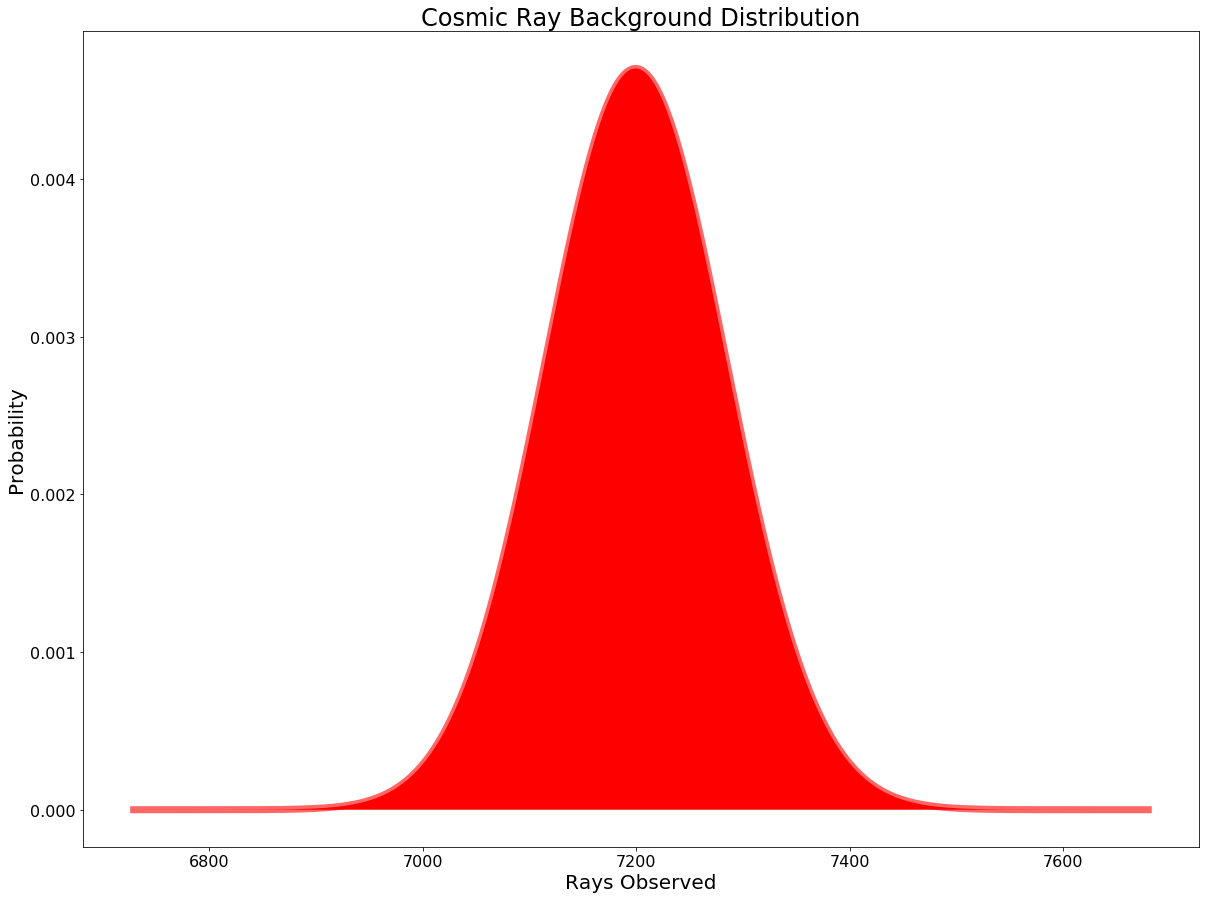

In [61]:
plt.rcParams["figure.figsize"] = (20,15)
mu = 15*8*60
fig, ax = plt.subplots(1, 1)
x = np.arange(stats.poisson.ppf(0.00000001, mu), stats.poisson.ppf(0.99999999, mu))
ax.plot(x, stats.poisson.pmf(x, mu),
       'r', lw=7, alpha=0.6, label='norm pdf')
ax.fill_between(x, stats.poisson.pmf(x, mu),
                 facecolor='red', interpolate=True)
plt.tick_params(labelsize = 16)
plt.title("Cosmic Ray Background Distribution"
          ,fontsize=24)
plt.xlabel("Rays Observed", fontsize = 20)
plt.ylabel('Probability', fontsize = 20)
plt.show()

#### 3. Convert to sigma.

We need to find the integral from 0 to 6800 cosmic rays seen, given a poisson distribution with a mu(average) of 7200. using cdf of the poisson distribution, I am able to find the probability to read 6800 cosmic rays. Putting one minus the probability into the ppf function for standardized normal distribution will give me the sigma significance, of the moon absorbing cosmic rays. 

In [62]:
p = stats.poisson.cdf(6800, mu)
s = stats.norm.ppf(1-p)
print("Probability: ", p)
print("Sigma significance: ", s)

Probability:  1.0133280183917768e-06
Sigma significance:  4.750747965778662


Given a poisson background distribution, set around a mean of 7200 cosmic rays, the probability of observing 6,800 cosmic rays, is approximately 0.00001%. This probability is associated with a sigma value of 4.75, therefore, we can reasonably say that this moon is absorbing cosmic rays.